In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import seaborn as sns
import io

from sklearn.preprocessing import LabelEncoder

In [47]:
font_path = "C:/Windows/Fonts/gulim.ttc"
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)              # 설정에 해당하는 rc params 변경

### 시각화 결과 1: 활동 유형별 빈도수 ###


C:\Users\minek\AppData\Local\Temp\ipykernel_588\832770109.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, y='cd_nm', order=df_final['cd_nm'].value_counts().index, palette='viridis')


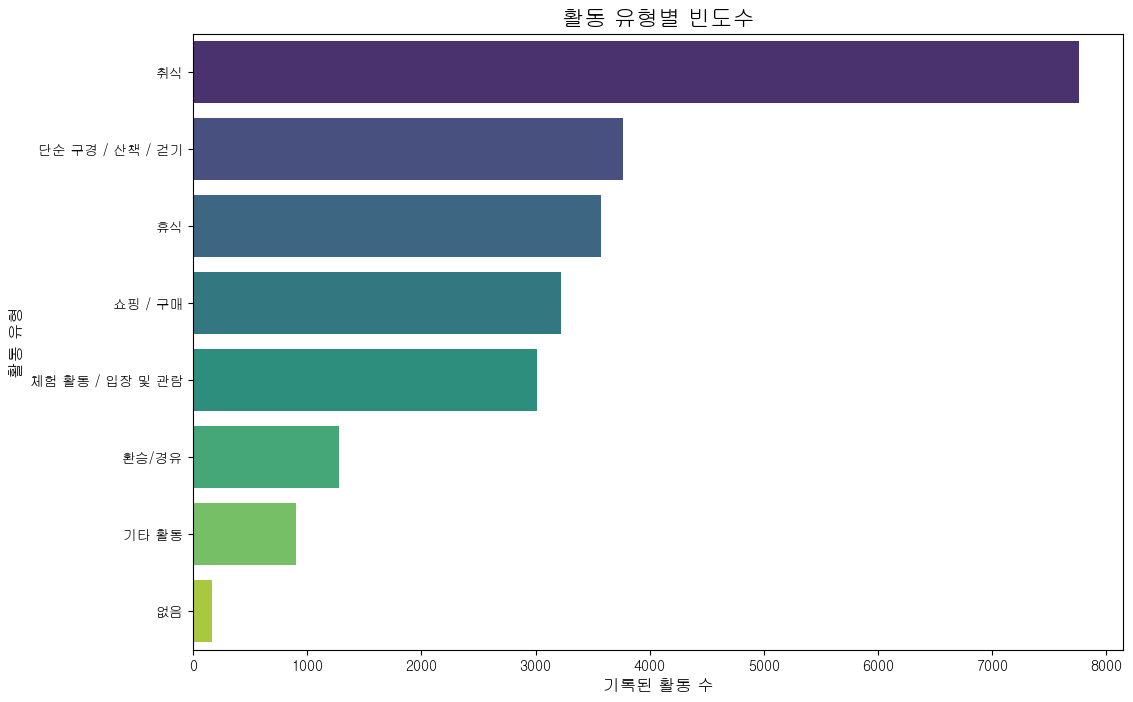


### 시각화 결과 2: 활동 유형별 예약 여부 비율 ###


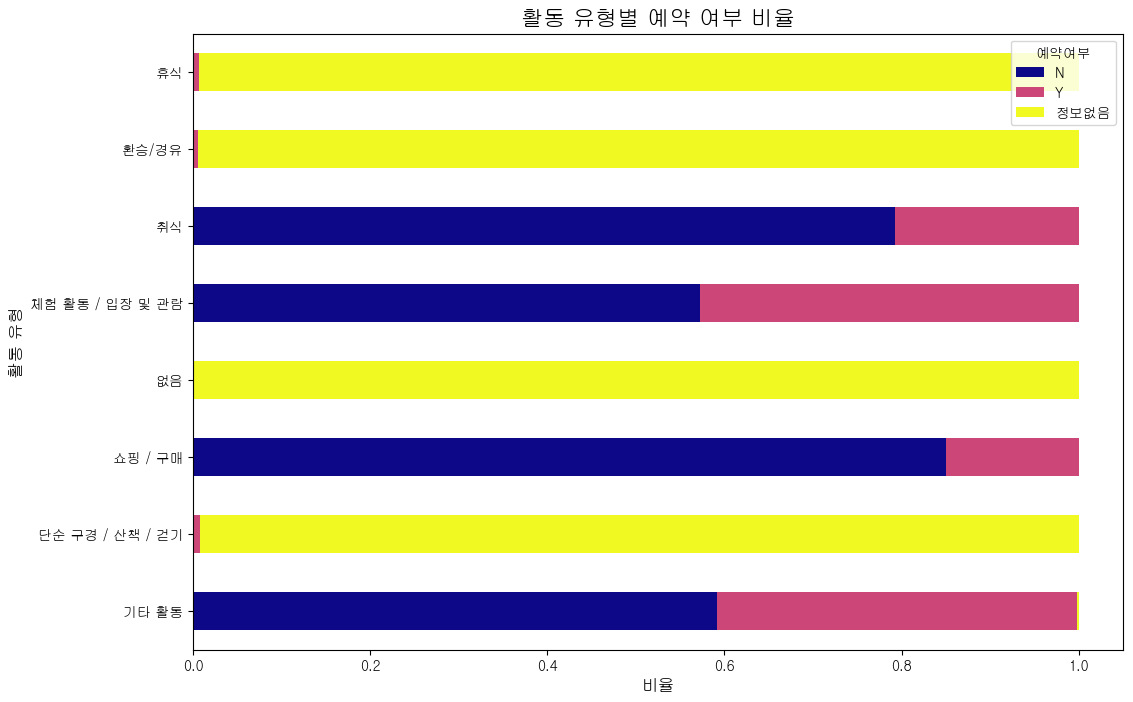

In [ ]:
# 1. '번역 사전' 데이터프레임
code_text = """idx,cd_a,cd_b,cd_nm
1055,ACT,"1","취식"
1056,ACT,"2","쇼핑 / 구매"
1057,ACT,"3","체험 활동 / 입장 및 관람"
1058,ACT,"4","단순 구경 / 산책 / 걷기"
1059,ACT,"5","휴식"
1060,ACT,"6","기타 활동"
1094,ACT,"7","환승/경유"
1096,ACT,"99","없음"
"""
# 불필요한 컬럼은 제외
df_codebook = pd.read_csv(io.StringIO(code_text))
df_codebook = df_codebook[['cd_b', 'cd_nm']] # 필요한 컬럼만 선택


# 2. 활동 내역 데이터를 로드하고 필수 전처리를 수행
df_activity = pd.read_csv('../../data/training/TL_csv/tn_activity_his_활동내역_E.csv')

cols_to_fill = ['ACTIVITY_DTL', 'RSVT_YN', 'EXPND_SE', 'ADMISSION_SE']
group_cols = ['TRAVEL_ID', 'VISIT_AREA_ID', 'ACTIVITY_TYPE_CD']
sort_keys = ['TRAVEL_ID', 'VISIT_AREA_ID', 'ACTIVITY_TYPE_CD', 'ACTIVITY_TYPE_SEQ']

df_activity_sorted = df_activity.sort_values(by=sort_keys)
df_activity_sorted[cols_to_fill] = df_activity_sorted.groupby(group_cols)[cols_to_fill].ffill()


# 3. 두 데이터를 병합하여 활동 코드를 활동명으로 변환
# 병합을 위해 키가 되는 컬럼의 데이터 타입을 문자열(str)로 통일
df_activity_sorted['ACTIVITY_TYPE_CD'] = df_activity_sorted['ACTIVITY_TYPE_CD'].astype(str)
df_codebook['cd_b'] = df_codebook['cd_b'].astype(str)

# left_on과 right_on을 사용하여 두 데이터프레임을 병합
df_final = pd.merge(df_activity_sorted, df_codebook, left_on='ACTIVITY_TYPE_CD', right_on='cd_b', how='left')


# 4. 활동명(cd_nm)을 사용하여 시각화를 다시 수행
print("### 시각화 결과 1: 활동 유형별 빈도수 ###")
plt.figure(figsize=(12, 8))
sns.countplot(data=df_final, y='cd_nm', order=df_final['cd_nm'].value_counts().index, palette='viridis')
plt.title('활동 유형별 빈도수', fontsize=16)
plt.xlabel('기록된 활동 수', fontsize=12)
plt.ylabel('활동 유형', fontsize=12)
plt.savefig('activity_frequency_by_name.png')
plt.show()


print("\n### 시각화 결과 2: 활동 유형별 예약 여부 비율 ###")
crosstab = pd.crosstab(df_final['cd_nm'], df_final['RSVT_YN'].fillna('정보없음'))
crosstab_ratio = crosstab.div(crosstab.sum(axis=1), axis=0)
crosstab_ratio.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='plasma')
plt.title('활동 유형별 예약 여부 비율', fontsize=16)
plt.xlabel('비율', fontsize=12)
plt.ylabel('활동 유형', fontsize=12)
plt.legend(title='예약여부')
plt.savefig('reservation_ratio_by_activity_name.png')
plt.show()

### preprocessing.py 적용사항

- `preprocess_activity_history()`에서 `load_dataset('활동내역')`을 사용해 데이터를 읽고 노트북의 정렬·ffill 로직을 함수화했습니다.
- `ACTIVITY_DTL`, `RSVT_YN`, `EXPND_SE`, `ADMISSION_SE` 열은 여행/방문/활동유형 단위로 forward fill하며 실제 존재하는 열만 선택해 안전하게 처리합니다.
- 내장 `load_activity_codebook()`으로 코드북을 불러 `ACTIVITY_TYPE_NM`을 추가하고, 필요 시 외부 코드북을 인자로 넣을 수 있도록 했습니다.
